<a href="https://colab.research.google.com/github/sandeeep-prajapati/pytorch_Practice_Repo/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))])

mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

D = D.to(device)
G = G.to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')


Epoch [0/200], Step [200/600], d_loss: 0.0347, g_loss: 4.5132, D(x): 0.99, D(G(z)): 0.03
Epoch [0/200], Step [400/600], d_loss: 0.0955, g_loss: 5.1095, D(x): 0.98, D(G(z)): 0.07
Epoch [0/200], Step [600/600], d_loss: 0.0277, g_loss: 5.1492, D(x): 0.99, D(G(z)): 0.02
Epoch [1/200], Step [200/600], d_loss: 0.2888, g_loss: 4.4323, D(x): 0.91, D(G(z)): 0.12
Epoch [1/200], Step [400/600], d_loss: 0.3815, g_loss: 2.9816, D(x): 0.90, D(G(z)): 0.19
Epoch [1/200], Step [600/600], d_loss: 0.8996, g_loss: 4.7674, D(x): 0.74, D(G(z)): 0.16
Epoch [2/200], Step [200/600], d_loss: 0.1745, g_loss: 4.4623, D(x): 0.93, D(G(z)): 0.05
Epoch [2/200], Step [400/600], d_loss: 0.2826, g_loss: 4.2738, D(x): 0.90, D(G(z)): 0.09
Epoch [2/200], Step [600/600], d_loss: 0.0916, g_loss: 6.2262, D(x): 0.96, D(G(z)): 0.03
Epoch [3/200], Step [200/600], d_loss: 0.4391, g_loss: 2.8097, D(x): 0.80, D(G(z)): 0.10
Epoch [3/200], Step [400/600], d_loss: 1.0163, g_loss: 2.5997, D(x): 0.65, D(G(z)): 0.14
Epoch [3/200], Step [

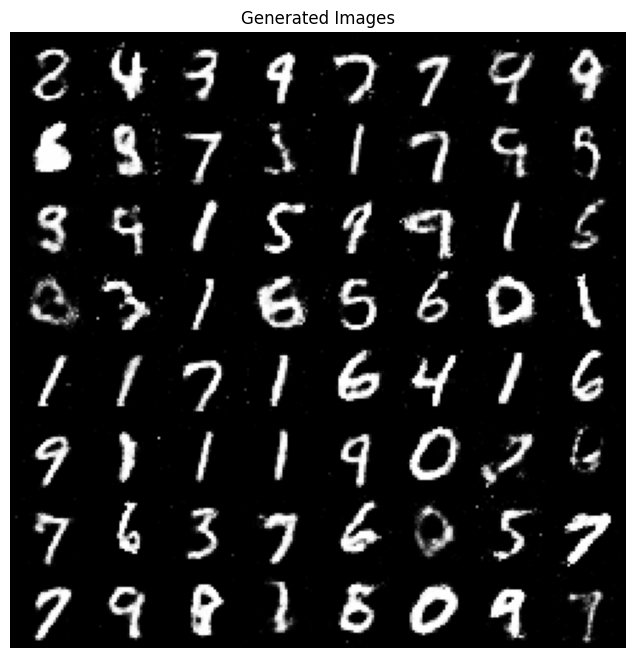

In [17]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Load the trained generator model
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)
G.load_state_dict(torch.load('G.ckpt'))
G.eval()  # Set the model to evaluation mode

# Number of images to generate
num_images = 64
# Generate random noise vectors
z = torch.randn(num_images, latent_size).to(device)
# Generate fake images
fake_images = G(z)
# Reshape fake images to appropriate shape (assuming image_size is 784 in this case)
fake_images = fake_images.view(-1, 1, 28, 28)
# Denormalize images
fake_images = denorm(fake_images)

# Save generated images
vutils.save_image(fake_images, 'generated_images.png', normalize=True)

# Display generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(fake_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))
plt.show()
